In [42]:
import cv2 as cv
import numpy as np
import importlib
import copy
import os
import torch

import os

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
import featexlib
from featexlib import Debug as dbug
from featexlib import *


%matplotlib inline

In [31]:
class Model_decorator(object):
    def __init__(self):
        self.model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
        
    def __call__(self, test_image):
        width = np.max(test_image.shape)
        return self.model(test_image, size=width).render()[0]

model = Model_decorator()

Using cache found in /home/tun/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-10-28 torch 1.10.0+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [34]:
###Create process class implementation      
class Production_unit(Production):
    def __init__(self):
        
        ###Initialize process layers
        self.layer_inp = Production.Layer_input(out_channel = 1)
        self.layer_1_cut = Production.Layer_cut(t=0,l=260,h=280,w=280, out_channel = 2)
        #self.layer_2_gray = Production.Layer_to_gray(invert=True, inp_channel = 6, out_channel = 2)
        #self.layer_3_rgb = Production.Layer_to_rgb(mode="b")
        self.layer_3_resize = Production.Layer_resize(w=256,h=256, inp_channel = 2, out_channel = 2)
        #self.layer_4_normalize = Production.Layer_normalize(mean_shift=0, std_offset_pos=2, std_offset_neg=2, inp_channel = 2, out_channel = 2)
        #self.layer_5_east_model = Production.Layer_bounding_box_east(pad_h=5, pad_w=5, color_scale = -1, score_threshold = 0.5, nms_treshold = 0.4, inp_channel = 2, out_channel = 3)
        #self.layer_5_scaler = Production.Layer_scaler(file="../../models/scalers/billid_256x256_unet_scaler_v_test_1.pkl", inp_channel = 2, out_channel = 3, astype='float32')
        self.layer_6_model = Production.Layer_model(model=model, input_shape = (256, 256, 3), output_shape = (256,256,3), inp_channel = 2, out_channel = 7)
        #self.layer_7_tresh = Production.Layer_treshold(ll=0.5, lh=1.0, inp_channel = 7, out_channel = 3)
        #self.layer_8_bbox = Production.Layer_bounding_box(pad_h=2, pad_w=2, w_roi_ct=128, w_roi_cl=128, w_k1 = 1, w_k2 = 1, w_sq = 2688, inp_channel = 3, out_channel = 3)
        #self.layer_9_cut_resize = Production.Layer_cut_bb_resize_rotate(w=84, h=32, inp_channel_1 = 2, inp_channel_2 = 3, out_channel = 4)
        #self.layer_9_1_gray = Production.Layer_to_gray(invert=True, inp_channel = 4, out_channel = 4)
        #self.layer_10_scaler = Production.Layer_scaler(file="../../models/scalers/dig4_256f_e5_cl2000_acc100_on_1000.pkl", inp_channel = 4, out_channel = 5, astype='float32')
        #self.layer_11_model = Production.Layer_model_feature(model=model_feat, input_shape = (-1,32,84,1), output_shape = (256), inp_channel = 5, out_channel = 5)
        #self.layer_show_bb = Production.Layer_show_bb(inp_channel_1 = 1, inp_channel_2 = 3, out_channel = 1)
        #self.layer_show_id = Production.Layer_add_id(id_module = Feature_detection((256,),
        #                                                 center_norm_lim=5, 
        #                                                 center_dist_norm_lim=5, 
        #                                                 likeness_lim = 3
        #                                                ), inp_channel_1 = 1, inp_channel_2 = 5, out_channel = 1)
        
        ###Initialise pipeline
        self.pipeline = Production.Pipeline_model_feat(
            proc_layers = [
                self.layer_inp,
                self.layer_1_cut,
                #self.layer_2_gray,
                self.layer_3_resize,
                #self.layer_4_normalize,
                #self.layer_5_east_model,
                #self.layer_5_scaler,
                self.layer_6_model,
                #self.layer_7_tresh,
                #self.layer_8_bbox,
                #self.layer_9_cut_resize,
                #self.layer_9_1_gray,
                #self.layer_10_scaler,
                #self.layer_11_model,
                #self.layer_show_bb,
                #self.layer_show_id
            ],
            inp_channel = 1,
            out_channels = (1,2,7)
        )
        
        super().__init__(self.pipeline)      

production = Production_unit()

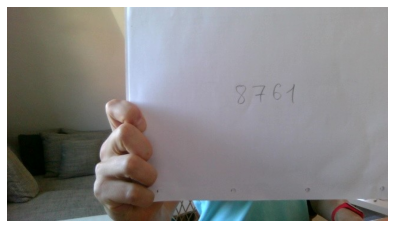

In [32]:
#Get some test images
test_images = Image_generator.load_from_folder("../../Data/4dig/test")
test_image = test_images[1]
test_image_1 = test_images[1]
test_image_2 = test_images[3]
Debug.show_images_list([test_image[:,:,[2,1,0]]],col_number = 2, height=7)

/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


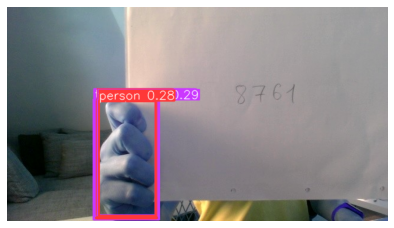

In [24]:
result = model(test_image)
Debug.show_images_list([result],col_number = 2, height=7)

/home/tun/.virtualenvs/ml/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Out shape (256, 256, 3)
out max 220  min 99  mean 158.94789123535156


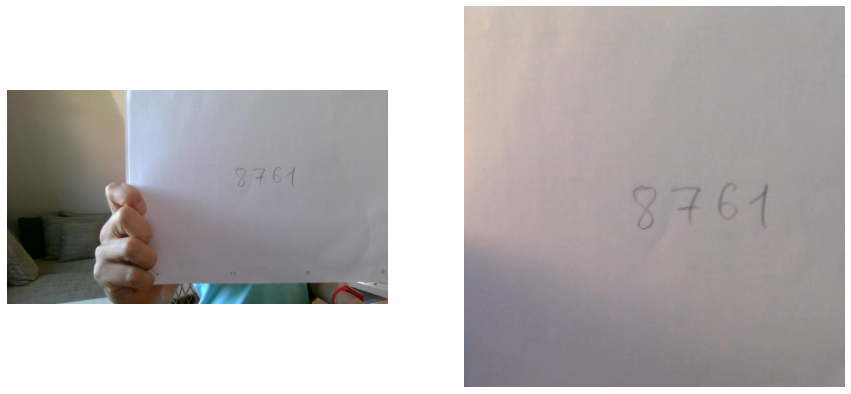

In [41]:
######################################FOR UNET TINY DETECTION
out = production(test_image)

if(out[2].data is not None):
    print("Out shape",out[2].data.shape)
    Debug.show_images_list([
        out[0].data[:,:,[2,1,0]],
        out[2].data
    ],
    col_number = 2, height=7)
else:
    print("Nothing detected")
    Debug.show_images_list([
        out[0].data[:,:,[2,1,0]],
    ],
    col_number = 4, height=5)
print("out max",out[2].data.max(), " min",out[2].data.min(), " mean",out[2].data.mean())
#dbug.Debug.show_images_list([test_image[:,:,[2,1,0]],out.data.reshape(out.data.shape[0],out.data.shape[1])], col_number = 4, height=5)
#dbug.Debug.show_images_list([test_image[:,:,[2,1,0]],out.data[:,:,[2,1,0]]], col_number = 4, height=5)